In [46]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, convolutional, normalization, Activation, Dropout, Flatten, pooling, Input
from keras.optimizers import Adam, SGD
from keras.regularizers import l2
from keras.initializers import VarianceScaling
from keras.utils import np_utils
from keras.callbacks import TensorBoard, ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
from keras import backend as K
from sklearn.model_selection import StratifiedShuffleSplit
from scipy import linalg
import csv

In [2]:
# I'd consider putting your datafiles in a ancenstor directory outside this file

train_images = pd.read_csv('../Hw2_data/train_data.csv', header=None).values.astype('float32')
train_labels = pd.read_csv('../Hw2_data/train_target.csv', header=None).values.astype('int32')

In [3]:
# ZCA whitening http://ufldl.stanford.edu/wiki/index.php/Implementing_PCA/Whitening
def whiten(image):
    # normalize
    image = image - np.mean(image) / np.std(image)

    # feature-wise center
    image = image - np.mean(image)

    # feature-wise std normalization
    image /= (np.std(image) + K.epsilon())

    sigma = np.dot(image.T, image) / image.shape[0]
    U, S, V = linalg.svd(sigma) # U = eigen values, S = eigen vector
    epsilon = 0.1 # 10e-7 is keras' default
    principal_components = np.dot(np.diag(1. / np.sqrt(S + epsilon)), U.T)
    
    return np.dot(image, np.dot(U, principal_components))

In [4]:
orig_images = train_images

# Preprocess images
train_images = whiten(train_images)

(16175, 2304) (16175, 1)


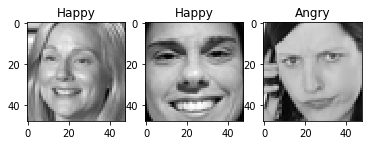

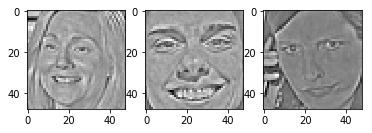

In [5]:
print(train_images.shape, train_labels.shape)

# Show samples from training data
images = orig_images.reshape(train_images.shape[0], 48, 48)
zca_images = train_images.reshape(train_images.shape[0], 48, 48)
n = 3
row = 3
labels = ['Angry', 'Happy', 'Neutral']
begin = 0 # can be random, but pick a number that reproduces results
for i in range(begin, begin + 3):
    plt.subplot(n//row, row, i%row+1)
    plt.imshow(images[i], cmap=plt.get_cmap('gray'))
    plt.title(labels[int(train_labels[i])])
plt.show()
for i in range(begin, begin + 3):
    plt.subplot(n//row, row, i%row+1)
    plt.imshow(zca_images[i], cmap=plt.get_cmap('gray'))
plt.show()

In [41]:
def split(X, Y, train_index, test_index):
    X, X_val = X[train_index], X[test_index]
    Y, Y_val = Y[train_index], Y[test_index]

    # Augment data
    
    train_aug_dir='../Hw2_data/images/training_augmented'
    if not os.path.exists(train_aug_dir):
        os.makedirs(train_aug_dir)
    test_aug_dir='../Hw2_data/images/test_augmented'
    if not os.path.exists(test_aug_dir):
        os.makedirs(test_aug_dir)

    train_datagen = ImageDataGenerator(
        rescale=1./255,
        zoom_range=0.2,
        horizontal_flip=True,
        data_format='channels_first'
    )
    train_datagen.fit(X)
    train_generator = train_datagen.flow(
        X,
        Y,
        seed=42,
        batch_size=batch_size,
#         save_to_dir=train_aug_dir # uncomment to see Data
    )

    validate_datagen = ImageDataGenerator(
        rescale=1./255,
        data_format='channels_first'
    )
    validate_datagen.fit(X_val)
    validate_generator = train_datagen.flow(
        X_val,
        Y_val,
        seed=42,
        batch_size=batch_size,
#         save_to_dir=test_aug_dir # uncomment to see Data
    )
    
    return (X, Y, X_val, Y_val, train_generator, validate_generator)

def train(model, aug_mult=2, epochs=20, batch_size=128):
    """
    Train a model
    """
    train_size = round(X_train.shape[0] * aug_mult)
    validate_size = round(X_validate.shape[0] * aug_mult)
    print('Augmented training split: ', train_size)
    print('Augmented test split: ', validate_size)
    
    # Adjust Learning Rate
    reduceLR = ReduceLROnPlateau(monitor='val_loss', factor=0.5, verbose=1)
    
    # Early stopping
    earlyStopper = EarlyStopping(verbose=1, patience=15)
    
    # Begin train
    history = model.fit_generator(
        train_generator, 
        epochs=epochs,
        steps_per_epoch=train_size // batch_size,
        validation_data=validate_generator,
        validation_steps=validate_size // batch_size,
        verbose=1,
        callbacks=[tbCallback, checkpoint, reduceLR, earlyStopper],
        workers=4
    )
    
    # Save the model
    model.save('../Hw2_data/model.h5')
    
    val_acc = max(history.history['val_acc'])
    print('Max val_acc: %.2f%%' % (val_acc * 100))
    return val_acc

In [62]:
def createFineTuneModel(lr=1e-4, batch_size=128):
    """
    Create a Model for fine tuning the top classifier
    """
    input_tensor = Input(shape=(48, 48, 3))
    base_model = VGG19(weights='imagenet', include_top=False, input_tensor=input_tensor)
#     top_model.add(Flatten(input_shape=base_model.output_shape[1:]))
    X = base_model.output
    X = pooling.GlobalAveragePooling2D()(X)
#     X = Flatten(input_shape=base_model.output_shape[1:])(X)
    X = Dense(256, activation='relu')(X)
    predictions = Dense(3, activation='softmax')(X)
        
    model = Model(input=base_model.input, output=predictions)
    for layer in base_model.layers:#[:15]:
        layer.trainable = False
    model.compile(
        optimizer=SGD(lr, momentum=0.9),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

def createModel(stacks=5, base_filter_size=32, lr=0.003):
    """
    Deep CNN
    
    Creates a Small Neural Net made for training small images batches
    
    References: 
    https://shuaiw.github.io/2017/01/24/deep-learning-for-logo-recognition-part-i.html
    http://lamda.nju.edu.cn/weixs/project/CNNTricks/CNNTricks.html
    """
    model = Sequential()

    # one limitation is that you can't specify which stacks need dropout, batch normalization, 
    # it is something I'll work on in the future
    for i in range(0, stacks):
        model.add(convolutional.Conv2D(
            filters=base_filter_size, 
            strides=(1,1),
            kernel_size=(3,3),
            input_shape=(1,48,48),
            data_format='channels_first',
            padding='same',
            kernel_initializer=VarianceScaling(scale=2.0, seed=42),
#             kernel_regularizer=l2(0.001)
        ))
        model.add(Activation('relu'))
        model.add(convolutional.Conv2D(
            filters=base_filter_size,
            strides=(1,1),
            kernel_size=(3,3),
            padding='same',
            kernel_initializer=VarianceScaling(scale=2.0, seed=42),
#             kernel_regularizer=l2(0.001)
        ))
        model.add(Activation('relu'))
        model.add(pooling.MaxPooling2D(
            pool_size=(2,2),
            padding='same'
        ))
        model.add(normalization.BatchNormalization())
        if base_filter_size < 256: # my GPU can't handle filters bigger than 256
            base_filter_size *= 2

    model.add(convolutional.Conv2D(
        filters=256,
        strides=(1,1),
        kernel_size=(3,3),
        padding='same',
        kernel_initializer=VarianceScaling(scale=2.0, seed=42),
#             kernel_regularizer=l2(0.001)
    ))
    model.add(Activation('relu'))
    model.add(pooling.MaxPooling2D(
        pool_size=(2,2),
        padding='same'
    ))
    model.add(normalization.BatchNormalization())
            
    # Flatten
    model.add(Flatten())
    
    model.add(Dense(128, kernel_initializer=VarianceScaling(scale=2.0, seed=42)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    model.add(Dense(64, kernel_initializer=VarianceScaling(scale=2.0, seed=42)))
    model.add(Activation('relu'))
    model.add(Dropout(0.5))
    
    # FC layer with softmax
    model.add(Dense(3))
    model.add(Activation('softmax'))
    
    # Use RMSprop + momentum
    opt = Adam(lr)

    # Choose loss function, optimization method, and metrics to display
    model.compile(
        optimizer = opt,
        loss = 'categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [8]:
test_size = 0.1 # since we augment the data to create a larger set, this should never really be changed
batch_size = 128 # This value seems good for GTX 980 4GB DDR3 without maxing out mem
aug_mult = 2 # increasing this will allow larger data, but increase epoch time

# Reshape
X = train_images.reshape(-1,1,48,48)    
Y = np_utils.to_categorical(train_labels, 3)

# Save best model
checkpoint = ModelCheckpoint('../Hw2_data/weights.best.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [22]:
runId = 27

In [ ]:
# train k-folds and average the validation accuracy
k = 1
total_val_acc = 0
sss = StratifiedShuffleSplit(n_splits=k, test_size=test_size, random_state=42)

# Split in a stratified way to make sure the training data covers all classes
for train_index, test_index in sss.split(X, Y):
    print('Train #%d: ' % runId)
    print('Train index: ', train_index)
    print('Test index: ', test_index)
    
    X_train, Y_train, X_validate, Y_validate, train_generator, validate_generator = split(X, Y, train_index, test_index)
    
    # Show loss and accuracy at each epoch in Tensorboard
    dir = './Graph/%d' % runId
    tbCallback = TensorBoard(log_dir=dir, histogram_freq=0, write_graph=True, write_images=True)
    
#     model = createFineTuneModel(
#         lr=1e-4
#     )
#     total_val_acc += train(
#         model,
#         aug_mult=aug_mult, 
#         epochs=5, # train on a few epochs
#         batch_size=batch_size
#     )
    
    model = createModel(
        stacks=4, # 2 Conv per stack
        base_filter_size=32, # increases by 2 per stack
        lr=0.000125#0.00001875 # based on batch normalization and dropout. Find a good learning rate starting from 0.0003
    )
    total_val_acc += train(
        model, 
        aug_mult=aug_mult, 
        epochs=10, # any number since we can early stop based on validation loss
        batch_size=batch_size
    )
        
    runId += 1

print ('Average val_acc: %.2f%%' % (total_val_acc / k * 100))
    
del model

Train #28: 
Train index:  [11961 10583 12555 ...,  8541 11607  3760]
Test index:  [ 3391  2079 16077 ...,  2741  4778 10531]
Augmented training split:  29114
Augmented test split:  3236


In [ ]:
# load and use the best weights
model = load_model('../Hw2_data/model.h5')
model.load_weights('../Hw2_data/weights.best.hdf5')

total_val_acc += train(
    model, 
    aug_mult=aug_mult, 
    epochs=1, # any number since we can early stop based on validation loss
    batch_size=batch_size
)

# load test data
test_images = pd.read_csv('../Hw2_data/test_data.csv', header=None).values.astype('float32')

sample_labels = pd.read_csv('../Hw2_data/sample-submission.csv')
sample_labels.set_index('Id')
sample_labels = sample_labels['Category'].values.astype('int32')

In [ ]:
result = whiten(test_images)
print(test_images.shape, sample_labels.shape)

In [ ]:
X_test = result.reshape(-1,1,48,48)
result = result.reshape(-1,1,48,48)

print(X_test.shape, test_images.shape)

i = 3
plt.subplot(1, 2, 1)
orig_image = test_images.reshape(test_images.shape[0], 48, 48)[i]
plt.title('Original')
plt.imshow(orig_image, cmap=plt.get_cmap('gray'))

plt.subplot(1, 2, 2)
test_image = result.reshape(result.shape[0], 48, 48)[i]
plt.title('ZCA Whitening')
plt.imshow(test_image, cmap=plt.get_cmap('gray'))

plt.show()

X_test /= 255
predictions = model.predict(X_test)

print(predictions.shape)

In [ ]:
with open('../Hw2_data/predictions-deep.csv', 'w', newline="") as file:
    writer = csv.writer(file)
    writer.writerow(('Id', 'Category'))
    for i in range(0, test_images.shape[0]):
        writer.writerow((i, np.argmax(predictions[i])))